# Covid Data Extraction-Analysis Automation Project

## Import

In [1]:
from selenium import webdriver
import time
import pandas as pd
from selenium.webdriver.support import expected_conditions as EC, wait
from selenium.webdriver.common.by import By
from selenium.webdriver.support.wait import WebDriverWait
from selenium.webdriver.support.ui import WebDriverWait
import os # delete files off computer
import sys # exit
import pyodbc # sql
from sqlalchemy import create_engine # sql to insert df to sql
import urllib # for sql too
import matplotlib.pyplot as plt
import geopandas
from mpl_toolkits.axes_grid1 import make_axes_locatable # for geopandas aligning of legend and graph
import datetime
import seaborn as sns # change format of graphs

## Download CSV File

In [2]:
# open covid data website
path = r"C:\Users\Abdulkadir\Documents\Programming\chromedriver.exe"
driver = webdriver.Chrome(path)
driver.get('https://ourworldindata.org/covid-deaths')
wait = WebDriverWait(driver, 5)

# download csv file
try:
    csvLink = wait.until(EC.presence_of_element_located((By.XPATH, "/html/body/main/article/div[3]/div[2]/div/div/section[1]/div/div[1]/div[1]/div/div/a[2]")))
    csvLink.click()
except:
    print('Download failed')
    sys.exit()

    
# file path of csv
filepath = r"C:\Users\Abdulkadir\Downloads\owid-covid-data.csv"


# load csv file into df
x = 1
while True:
    try:
        csv = pd.read_csv(filepath)
        print('CSV succesfully downloaded.')
        break
    except:
        print(f'CSV downloading... {x}/100.')
        x += 1
        time.sleep(3)
    
    if x == 30:
        print('CSV Failed')
        #sys.exit()

# close driver
driver.close()
        
# delete the csv file off my computer so it does not interfere with downlaoding new data and names
try:
    os.remove(filepath)
    print('CSV successfully deleted.')
except:
    print('CSV does not exist.')

CSV downloading... 1/100.
CSV downloading... 2/100.
CSV downloading... 3/100.
CSV downloading... 4/100.
CSV succesfully downloaded.
CSV successfully deleted.


## Take Relevant Data

In [3]:
data = csv[['iso_code', 'continent', 'location', 'date', 'population', 'total_cases', 'new_cases', 'total_deaths', 'new_deaths', 'total_vaccinations', 'new_vaccinations']]

# make NaN into 0
data = data.fillna(0)
data

,iso_code,continent,location,date,population,total_cases,new_cases,total_deaths,new_deaths,total_vaccinations,new_vaccinations
0,AFG,Asia,Afghanistan,2020-02-24,39835428.0,5.0,5.0,0.0,0.0,0.0,0.0
1,AFG,Asia,Afghanistan,2020-02-25,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
2,AFG,Asia,Afghanistan,2020-02-26,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
3,AFG,Asia,Afghanistan,2020-02-27,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
4,AFG,Asia,Afghanistan,2020-02-28,39835428.0,5.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
179213,ZWE,Africa,Zimbabwe,2022-04-11,15092171.0,247010.0,52.0,5460.0,3.0,10043468.0,18341.0
179214,ZWE,Africa,Zimbabwe,2022-04-12,15092171.0,247094.0,84.0,5460.0,0.0,10074016.0,30548.0
179215,ZWE,Africa,Zimbabwe,2022-04-13,15092171.0,247160.0,66.0,5460.0,0.0,10082431.0,8415.0
179216,ZWE,Africa,Zimbabwe,2022-04-14,15092171.0,247208.0,48.0,5462.0,2.0,10108149.0,25718.0


## Store Data in SQL

In [4]:
SERVER_NAME = 'DESKTOP-GR6T3L7'
DATABASE_NAME = 'Covid Project'

# connection string
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + SERVER_NAME + '; \
                       DATABASE=' + DATABASE_NAME + '; \
                       Trusted_Connection=yes')

# cursor to extract data
cursor = conn.cursor()

# Use this to connect for saving data
quoted = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER='+SERVER_NAME+'; \
                       DATABASE='+DATABASE_NAME+'; \
                       Trusted_Connection=yes')

# save the dataset into SQL database
engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))
data.to_sql('Automation', schema='dbo', con=engine, if_exists='replace')
print('Dataset updated.')

# close connection adn remove cursor
cursor.close()
conn.close()

Dataset updated.


## Analysis using Pandas

#### ------------------------- Deaths per cases in the United Kingdom -------------------------

In [5]:
# Finding the percentage of total deaths per total case for each day in the uk
DeathsPerCase = (data['total_deaths'] / data['total_cases']) * 100

# make it into df
DeathsPerCase = pd.DataFrame(DeathsPerCase, columns=['deaths_per_cases'])

# data needed
table_1 = data[['location', 'date', 'total_cases', 'total_deaths']]

# combines the new variable column to table 1
first_analysis = table_1.join(DeathsPerCase)

# filter data for only location in united kingdom
is_UK = first_analysis['location'] == 'United Kingdom'
first_analysis = first_analysis[is_UK]
first_analysis

#### update: better way to make an extra column ####
# table_1['deaths_per_cases'] = (data['total_deaths'] / data['total_cases']) * 100
# table_1

,location,date,total_cases,total_deaths,deaths_per_cases
168026,United Kingdom,2020-01-31,2.0,0.0,0.000000
168027,United Kingdom,2020-02-01,2.0,0.0,0.000000
168028,United Kingdom,2020-02-02,2.0,0.0,0.000000
168029,United Kingdom,2020-02-03,8.0,0.0,0.000000
168030,United Kingdom,2020-02-04,8.0,0.0,0.000000
...,...,...,...,...,...
168827,United Kingdom,2022-04-11,21711142.0,170264.0,0.784224
168828,United Kingdom,2022-04-12,21749699.0,170552.0,0.784158
168829,United Kingdom,2022-04-13,21787105.0,171210.0,0.785832
168830,United Kingdom,2022-04-14,21819851.0,171560.0,0.786257


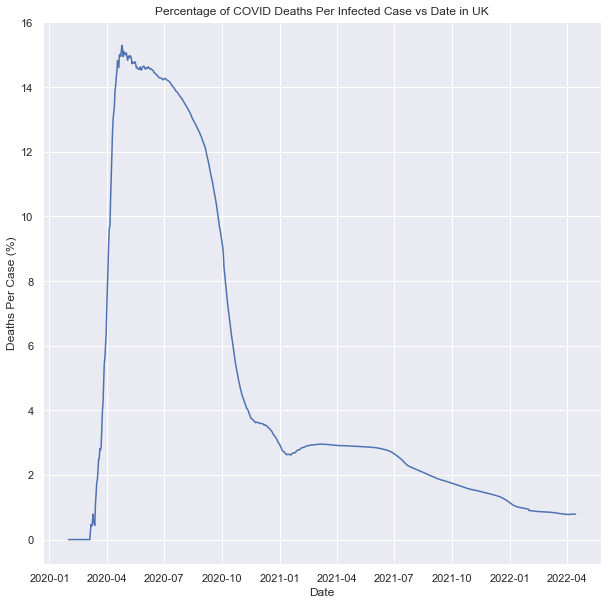

In [6]:
# change x axis incrementation because it is too much: do this by changing string date to datetime
first_analysis['date'] = pd.to_datetime(first_analysis['date'])

# set seaborn theme
sns.set_theme()

# plot a bar chart
plt.figure(figsize=(10,10))

# labelling
plt.title('Percentage of COVID Deaths Per Infected Case vs Date in UK')
plt.xlabel('Date')
plt.ylabel("Deaths Per Case (%)")

# line graph
plt.plot(first_analysis.date, first_analysis.deaths_per_cases)

# show
plt.show()

#### -------------------- Percentage of total cases in the United Kingdom vs Time --------------------

In [7]:
# total cases per popualtion variable
TotCasesPerPopPerc = (data['total_cases'] / data['population']) * 100
TotCasesPerPopPerc = pd.DataFrame(TotCasesPerPopPerc, columns=['total_cases_per_population_percentage'])

second_analysis = data[['location', 'date']].join(TotCasesPerPopPerc)
second_analysis = second_analysis[is_UK]
second_analysis

,location,date,total_cases_per_population_percentage
168026,United Kingdom,2020-01-31,0.000003
168027,United Kingdom,2020-02-01,0.000003
168028,United Kingdom,2020-02-02,0.000003
168029,United Kingdom,2020-02-03,0.000012
168030,United Kingdom,2020-02-04,0.000012
...,...,...,...
168827,United Kingdom,2022-04-11,31.831199
168828,United Kingdom,2022-04-12,31.887728
168829,United Kingdom,2022-04-13,31.942570
168830,United Kingdom,2022-04-14,31.990579


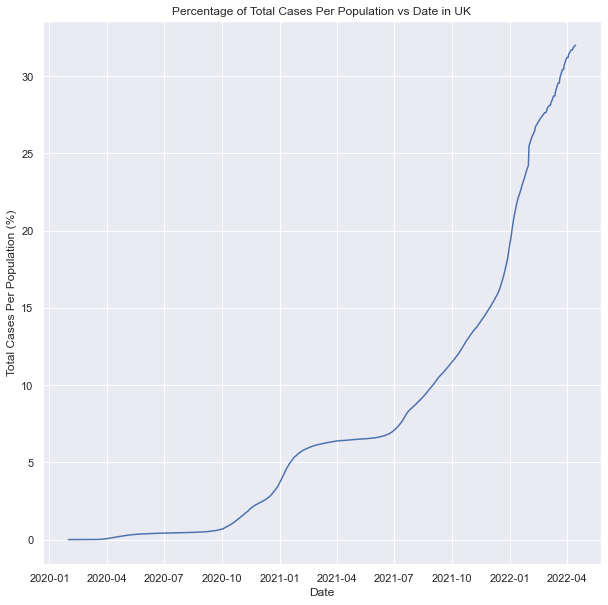

In [8]:
# change x axis incrementation because it is too much: do this by changing string date to datetime
second_analysis['date'] = pd.to_datetime(second_analysis['date'])

# plot a bar chart
plt.figure(figsize=(10,10))

# labelling
plt.title('Percentage of Total Cases Per Population vs Date in UK')
plt.xlabel('Date')
plt.ylabel("Total Cases Per Population (%)")

# line graph
plt.plot(second_analysis.date, second_analysis.total_cases_per_population_percentage)

# show
plt.show()

#### -------------------- Death percentage in the world -------------------------

In [9]:
# relevant data
third_analysis = data[['iso_code', 'continent', 'location', 'new_cases', 'new_deaths']]
third_analysis

# group by location and continent
is_grouped = third_analysis.groupby(['iso_code', 'location', 'continent']).sum()
is_grouped.rename(columns={"new_cases":"total_cases", "new_deaths":"total_deaths"}, inplace=True)

# death percentage
deathPercentage = (is_grouped['total_deaths'] / is_grouped['total_cases']) * 100
deathPercentage = pd.DataFrame(deathPercentage, columns=['death_percentage'])

# combine death percentage to grouped table
combined_table = is_grouped.join(deathPercentage)

# remove NaN
combined_table['death_percentage'] = combined_table['death_percentage'].fillna(0)

# remove continent with values of 0 to get rid of continents and only leave countries
death_percentage_table = combined_table.query("continent!=0")

# remove death percentage
death_percentage_table = death_percentage_table[death_percentage_table['death_percentage'] > 0]

# sort table by total_deaths desc
death_percentage_table.sort_values(by='total_deaths', ascending=False, inplace=True)

# fixes grouping issues and accessing grouped columns
death_percentage_table.reset_index(inplace=True)
death_percentage_table

,iso_code,location,continent,total_cases,total_deaths,death_percentage
0,USA,United States,North America,80612680.0,988558.0,1.226306
1,BRA,Brazil,South America,30142220.0,662154.0,2.196766
2,IND,India,Asia,43040947.0,514374.0,1.195081
3,RUS,Russia,Europe,17790211.0,365540.0,2.054725
4,MEX,Mexico,North America,5725476.0,316842.0,5.533898
...,...,...,...,...,...,...
203,VUT,Vanuatu,Oceania,6109.0,7.0,0.114585
204,WLF,Wallis and Futuna,Oceania,454.0,7.0,1.541850
205,PLW,Palau,Oceania,4190.0,6.0,0.143198
206,MSR,Montserrat,North America,176.0,3.0,1.704545


#### Map Visualisation of Geographical Data

In [10]:
# get world data from geopandas
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"MULTIPOLYGON (((180.00000 -16.06713, 180.00000..."
1,53950935,Africa,Tanzania,TZA,150600.0,"POLYGON ((33.90371 -0.95000, 34.07262 -1.05982..."
2,603253,Africa,W. Sahara,ESH,906.5,"POLYGON ((-8.66559 27.65643, -8.66512 27.58948..."
3,35623680,North America,Canada,CAN,1674000.0,"MULTIPOLYGON (((-122.84000 49.00000, -122.9742..."
4,326625791,North America,United States of America,USA,18560000.0,"MULTIPOLYGON (((-122.84000 49.00000, -120.0000..."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982 45.90887, 18.82984 45.90888..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070 42.58863, 19.80161 42.50009..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000 10.76000, -61.10500 10.890..."


In [11]:
# compare iso codes
pd.set_option('display.max_rows', 208)

In [12]:
death_percentage_table.sort_values(by='iso_code', ascending=True, inplace=True)
death_percentage_table

,iso_code,location,continent,total_cases,total_deaths,death_percentage
163,ABW,Aruba,North America,34345.0,213.0,0.620178
71,AFG,Afghanistan,Asia,178381.0,7676.0,4.303149
115,AGO,Angola,Africa,99194.0,1903.0,1.918463
202,AIA,Anguilla,North America,2731.0,10.0,0.366166
95,ALB,Albania,Europe,274429.0,3495.0,1.273553
171,AND,Andorra,Europe,40709.0,155.0,0.380751
109,ARE,United Arab Emirates,Asia,895018.0,2302.0,0.257202
13,ARG,Argentina,South America,9059944.0,128327.0,1.416422
67,ARM,Armenia,Asia,422729.0,8623.0,2.039841
174,ATG,Antigua and Barbuda,North America,7537.0,135.0,1.791164


In [13]:
world.sort_values(by='iso_a3', ascending=True, inplace=True)
world

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
174,1895250,Europe,Kosovo,-99,18490.00,"POLYGON ((20.59025 41.85541, 20.52295 42.21787..."
21,5320045,Europe,Norway,-99,364700.00,"MULTIPOLYGON (((15.14282 79.67431, 15.52255 80..."
167,3500000,Africa,Somaliland,-99,12250.00,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
43,67106161,Europe,France,-99,2699000.00,"MULTIPOLYGON (((-51.65780 4.15623, -52.24934 3..."
160,265100,Asia,N. Cyprus,-99,3600.00,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
103,34124811,Asia,Afghanistan,AFG,64080.00,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
74,29310273,Africa,Angola,AGO,189000.00,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
125,3047987,Europe,Albania,ALB,33900.00,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
84,6072475,Asia,United Arab Emirates,ARE,667200.00,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
9,44293293,South America,Argentina,ARG,879400.00,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000..."


In [14]:
# fix iso codes to match
world.at[21,'iso_a3'] = 'NOR'
world.at[174,'iso_a3'] = 'OWID_KOS'
# somaliland not in my dataset
world.at[43,'iso_a3'] = 'FRA'
# N. Cyprus not in my dataset

world.sort_values(by='iso_a3', ascending=True, inplace=True)
pd.set_option('display.max_rows', 10) #177 countries before joining
world_iso_sorted = world
world_iso_sorted

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
167,3500000,Africa,Somaliland,-99,12250.0,"POLYGON ((48.94820 11.41062, 48.94820 11.41062..."
160,265100,Asia,N. Cyprus,-99,3600.0,"POLYGON ((32.73178 35.14003, 32.80247 35.14550..."
103,34124811,Asia,Afghanistan,AFG,64080.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614..."
74,29310273,Africa,Angola,AGO,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4..."
125,3047987,Europe,Albania,ALB,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
...,...,...,...,...,...,...
89,282814,Oceania,Vanuatu,VUT,723.0,"MULTIPOLYGON (((167.21680 -15.89185, 167.84488..."
157,28036829,Asia,Yemen,YEM,73450.0,"POLYGON ((52.00001 19.00000, 52.78218 17.34974..."
25,54841552,Africa,South Africa,ZAF,739100.0,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082..."
70,15972000,Africa,Zambia,ZMB,65170.0,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458..."


In [15]:
# join my dataset with world dataset for map visualisation -- not all data will be merged therefore this is only for quick visual purposes. Dashboard will be created using Tableau/Excel
merged_data_1 = world_iso_sorted.merge(death_percentage_table, how='left', left_on=['iso_a3'], right_on=['iso_code'])

# drop NaN
merged_data_1 = merged_data_1.dropna(subset=['iso_code'])
merged_data_1

,pop_est,continent_x,name,iso_a3,gdp_md_est,geometry,iso_code,location,continent_y,total_cases,total_deaths,death_percentage
2,34124811,Asia,Afghanistan,AFG,64080.0,"POLYGON ((66.51861 37.36278, 67.07578 37.35614...",AFG,Afghanistan,Asia,178381.0,7676.0,4.303149
3,29310273,Africa,Angola,AGO,189000.0,"MULTIPOLYGON (((12.99552 -4.78110, 12.63161 -4...",AGO,Angola,Africa,99194.0,1903.0,1.918463
4,3047987,Europe,Albania,ALB,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",ALB,Albania,Europe,274429.0,3495.0,1.273553
5,6072475,Asia,United Arab Emirates,ARE,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",ARE,United Arab Emirates,Asia,895018.0,2302.0,0.257202
6,44293293,South America,Argentina,ARG,879400.0,"MULTIPOLYGON (((-68.63401 -52.63637, -68.25000...",ARG,Argentina,South America,9059944.0,128327.0,1.416422
...,...,...,...,...,...,...,...,...,...,...,...,...
172,282814,Oceania,Vanuatu,VUT,723.0,"MULTIPOLYGON (((167.21680 -15.89185, 167.84488...",VUT,Vanuatu,Oceania,6109.0,7.0,0.114585
173,28036829,Asia,Yemen,YEM,73450.0,"POLYGON ((52.00001 19.00000, 52.78218 17.34974...",YEM,Yemen,Asia,11818.0,2148.0,18.175664
174,54841552,Africa,South Africa,ZAF,739100.0,"POLYGON ((16.34498 -28.57671, 16.82402 -28.082...",ZAF,South Africa,Africa,3720606.0,99819.0,2.682869
175,15972000,Africa,Zambia,ZMB,65170.0,"POLYGON ((30.74001 -8.34001, 31.15775 -8.59458...",ZMB,Zambia,Africa,318404.0,3970.0,1.246844


<AxesSubplot:title={'center':'Global Total Deaths Per Cases'}>

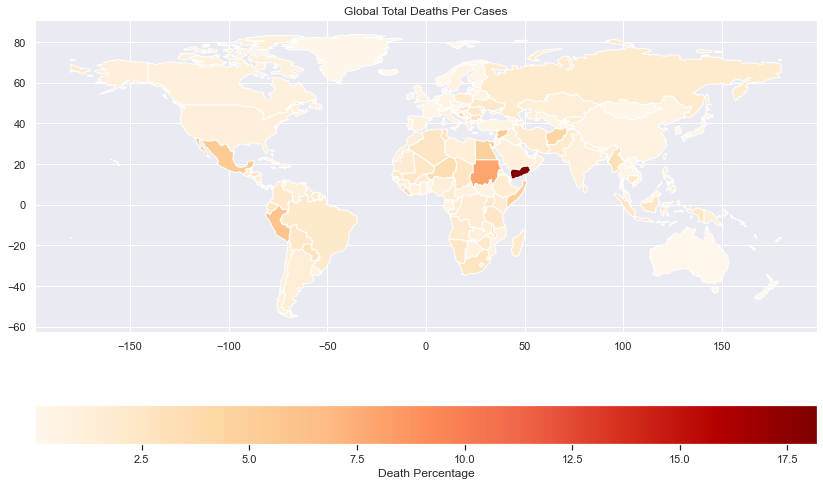

In [16]:
# geopandas plot
fig, ax = plt.subplots(1, 1, figsize=(14,9))
plt.title('Global Total Deaths Per Cases')

merged_data_1.plot(column='death_percentage', ax=ax, legend=True, legend_kwds={'label': 'Death Percentage', 'orientation':'horizontal'}, cmap='OrRd')

<Figure size 1080x1080 with 0 Axes>

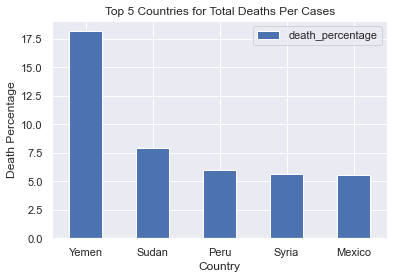

In [17]:
# top 5 countries global death percentage
top_5_1 = merged_data_1
top_5_1.sort_values(by='death_percentage', ascending=False, inplace=True)
top_5_1 = top_5_1.head(5)

# plot a bar chart
plt.figure(figsize=(15,15))

# bar chart
top_5_1 = top_5_1.plot.bar(x='location', y='death_percentage', rot=-0)

# labels
plt.xlabel('Country')
plt.ylabel('Death Percentage')
plt.title('Top 5 Countries for Total Deaths Per Cases')

# show
plt.show()

#### -------------------- Infection rate by looking at total cases against population -------------------------

In [18]:
# Relevant data
fourth_analysis = data[['iso_code', 'continent', 'location', 'population', 'total_cases']]

# Infection rate: Max total cases / population, group by continent location population
is_grouped_2 = fourth_analysis.groupby(['iso_code', 'location', 'continent']).max()

# Infection rate
infection_rate = (is_grouped_2['total_cases'] / is_grouped_2['population'])*100
infection_rate = pd.DataFrame(infection_rate, columns=['infection_rate'])

# Combine the column with the table
combined_table_2 = is_grouped_2.join(infection_rate)
combined_table_2.sort_values(by=['infection_rate'], ascending=False, inplace=True)

# remove continent with values of 0 to get rid of continents and only leave countries
combined_table_2 = combined_table_2.query("continent!=0 and total_cases!=0")

# remove NaN
combined_table_2['infection_rate'] = combined_table_2['infection_rate'].fillna(0)
combined_table_2

# fixes grouping issues and accessing grouped columns
combined_table_2.reset_index(inplace=True)
combined_table_2

,iso_code,location,continent,population,total_cases,infection_rate
0,FRO,Faeroe Islands,Europe,49053.0,34658.0,70.654190
1,DNK,Denmark,Europe,5813302.0,3095605.0,53.250373
2,AND,Andorra,Europe,77354.0,40709.0,52.626884
3,GIB,Gibraltar,Europe,33691.0,17494.0,51.924846
4,CYP,Cyprus,Europe,896005.0,464366.0,51.826273
...,...,...,...,...,...,...
210,YEM,Yemen,Asia,30490639.0,11817.0,0.038756
211,NER,Niger,Africa,25130810.0,8866.0,0.035279
212,MAC,Macao,Asia,658391.0,82.0,0.012455
213,MHL,Marshall Islands,Oceania,59618.0,7.0,0.011741


Geopandas Visualisation

In [19]:
# merge on iso code
merged_data_2 = world_iso_sorted.merge(combined_table_2, how='left', left_on=['iso_a3'], right_on=['iso_code'])

# drop NaN
merged_data_2 = merged_data_2.dropna(subset=['iso_code'])

<AxesSubplot:title={'center':'Global Infection Per Population'}>

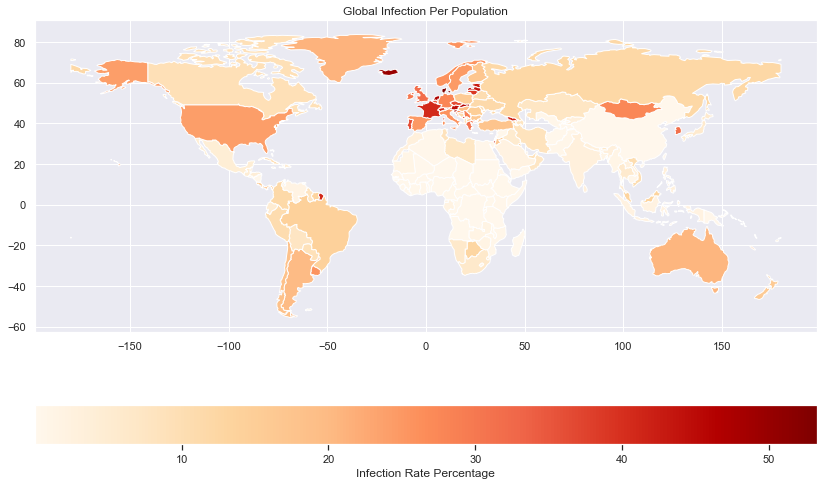

In [20]:
# geopandas plot
fig, ax = plt.subplots(1, 1, figsize=(14,9))
plt.title('Global Infection Per Population')

merged_data_2.plot(column='infection_rate', ax=ax, legend=True, legend_kwds={'label': 'Infection Rate Percentage', 'orientation':'horizontal'}, cmap='OrRd')

<Figure size 1080x1080 with 0 Axes>

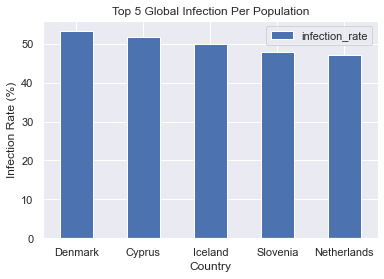

In [48]:
# top 5 countries global infection percentage
top_5_2 = merged_data_2
top_5_2.sort_values(by='infection_rate', ascending=False, inplace=True)
top_5_2 = top_5_2.head(5)

# plot a bar chart
plt.figure(figsize=(15,15))

# bar chart
top_5_2 = top_5_2.plot.bar(x='location', y='infection_rate', rot=-0)

# labels
plt.xlabel('Country')
plt.ylabel('Infection Rate (%)')
plt.title('Top 5 Global Infection Per Population')

# show
plt.show()

#### -------------------- Death percentage for each country --------------------

In [22]:
# Relevant data#
fifth_analysis = data[['iso_code', 'location', 'continent', 'population', 'total_deaths']]
fifth_analysis.head(50)

# Group data
is_grouped_3 = fifth_analysis.groupby(['iso_code', 'location', 'continent']).max()

# Total deaths per population
deaths_per_population = (is_grouped_3['total_deaths'] / is_grouped_3['population'])*100
deaths_per_population = pd.DataFrame(deaths_per_population, columns=['deaths_per_population_percentage'])

# Join deaths per population to table
combined_table_3 = is_grouped_3.join(deaths_per_population)
combined_table_3.sort_values(by=['total_deaths'], ascending=False, inplace=True)

# remove continent with values of 0 to get rid of continents and only leave countries
combined_table_3 = combined_table_3.query("continent!=0 and total_deaths!=0")

# remove NaN
combined_table_3['deaths_per_population_percentage'] = combined_table_3['deaths_per_population_percentage'].fillna(0)
combined_table_3

# fixes grouping issues and accessing grouped columns
combined_table_3.reset_index(inplace=True)
combined_table_3

,iso_code,location,continent,population,total_deaths,deaths_per_population_percentage
0,USA,United States,North America,3.329151e+08,988558.0,0.296940
1,BRA,Brazil,South America,2.139934e+08,662154.0,0.309427
2,IND,India,Asia,1.393409e+09,521747.0,0.037444
3,RUS,Russia,Europe,1.459120e+08,365540.0,0.250521
4,MEX,Mexico,North America,1.302622e+08,323903.0,0.248655
...,...,...,...,...,...,...
203,WLF,Wallis and Futuna,Oceania,1.109400e+04,7.0,0.063097
204,VUT,Vanuatu,Oceania,3.144640e+05,7.0,0.002226
205,PLW,Palau,Oceania,1.817400e+04,6.0,0.033014
206,MSR,Montserrat,North America,4.981000e+03,3.0,0.060229


Geopandas Death Percentage Visualisation --> The death percent relative to a countries population

In [23]:
# merge on iso code
merged_data_3 = world_iso_sorted.merge(combined_table_3, how='left', left_on=['iso_a3'], right_on=['iso_code'])

# drop NaN
merged_data_3 = merged_data_3.dropna(subset=['iso_code'])

<AxesSubplot:title={'center':'Global Death Per Population'}>

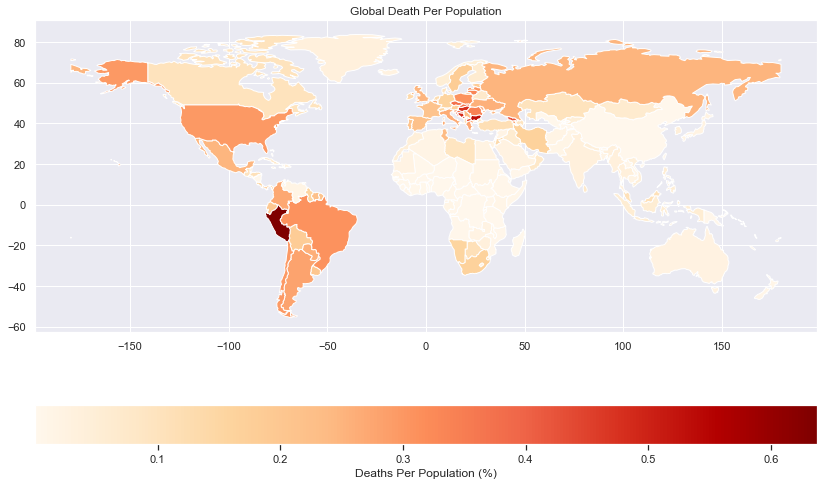

In [24]:
# geopandas plot
fig, ax = plt.subplots(1, 1, figsize=(14,9))
plt.title('Global Death Per Population')

merged_data_3.plot(column='deaths_per_population_percentage', ax=ax, legend=True, legend_kwds={'label': 'Deaths Per Population (%)', 'orientation':'horizontal'}, cmap='OrRd')

In [ ]:
# top 5 global death rate by population
top_5_3 = merged_data_3
top_5_3.sort_values(by='deaths_per_population_percentage', ascending=False, inplace=True)
top_5_3 = top_5_3.head(5)

# plot a bar chart
plt.figure(figsize=(15,15))

# bar chart
top_5_3 = top_5_3.plot.bar(x='location', y='deaths_per_population_percentage', rot=-0)

# labels
plt.xlabel('Country')
plt.ylabel('Deaths Per Population (%))')
plt.title('Top 5 Global Deaths Per Population')

# show
plt.show()

<Figure size 1080x1080 with 0 Axes>

#### -------------------- Continental Death Count --------------------

In [26]:
# relevant data
sixth_analysis = data[['location', 'continent', 'total_deaths']]

# group data
is_grouped_5 = sixth_analysis.groupby(['location', 'continent']).max()

# keep continents only
is_grouped_5 = is_grouped_5.query("continent==0")
is_grouped_5.sort_values(by=['total_deaths'], ascending=False, inplace=True)

# only keep europe, north america, asia, south america, africa, oceania
is_grouped_5 = is_grouped_5.query("(location=='Europe') | (location=='North America') | (location=='Asia') | (location=='South America') | (location=='Africa') | (location=='Oceania')")
is_grouped_5

# fixes grouping issues and accessing grouped columns
is_grouped_5.reset_index(inplace=True)
is_grouped_5 = is_grouped_5[['location', 'total_deaths']]
is_grouped_5

,location,total_deaths
0,Europe,1797973.0
1,North America,1423989.0
2,Asia,1419646.0
3,South America,1291586.0
4,Africa,252476.0
5,Oceania,9962.0


Continental visualisation

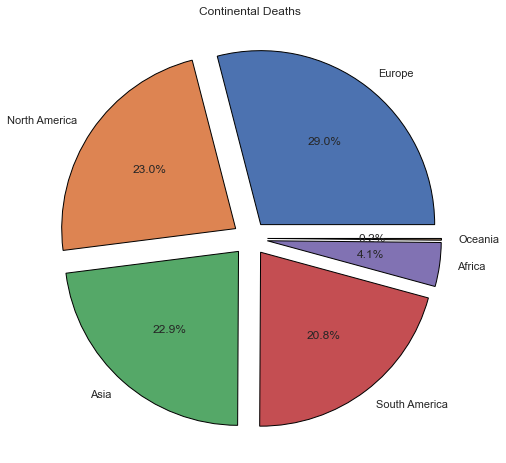

In [27]:
# explode.. make pie chart apart
explode = [0.1, 0.1, 0.1, 0.1, 0.1, 0.1]

# plot a bar chart
plt.figure(figsize=(8,8))

# bar chart
plt.pie(is_grouped_5['total_deaths'], labels=is_grouped_5['location'], autopct='%1.1f%%', explode=explode, wedgeprops={'edgecolor': 'black'})

# title
plt.title('Continental Deaths')
plt.ticklabel_format(style='plain', axis='y')



#### -------------------- World Deaths Per Cases vs Date --------------------

In [28]:
# relevant data
seventh_analysis = data[['location', 'date', 'new_cases', 'new_deaths']]

# world data
world_data = seventh_analysis.query("(location=='World') and (new_cases!=0)")
world_data

# death percentage
deaths_per_cases = (world_data['new_deaths'] / world_data['new_cases']) * 100
deaths_per_cases = pd.DataFrame(deaths_per_cases, columns=['deaths_per_case'])

# combined
daily_death_per_case = world_data.join(deaths_per_cases)
daily_death_per_case

,location,date,new_cases,new_deaths,deaths_per_case
176152,World,2020-01-23,100.0,1.0,1.000000
176153,World,2020-01-24,287.0,8.0,2.787456
176154,World,2020-01-25,493.0,16.0,3.245436
176155,World,2020-01-26,683.0,14.0,2.049780
176156,World,2020-01-27,809.0,26.0,3.213844
...,...,...,...,...,...
176961,World,2022-04-11,975317.0,2948.0,0.302261
176962,World,2022-04-12,1036861.0,3303.0,0.318558
176963,World,2022-04-13,1039901.0,4553.0,0.437830
176964,World,2022-04-14,971952.0,3808.0,0.391789


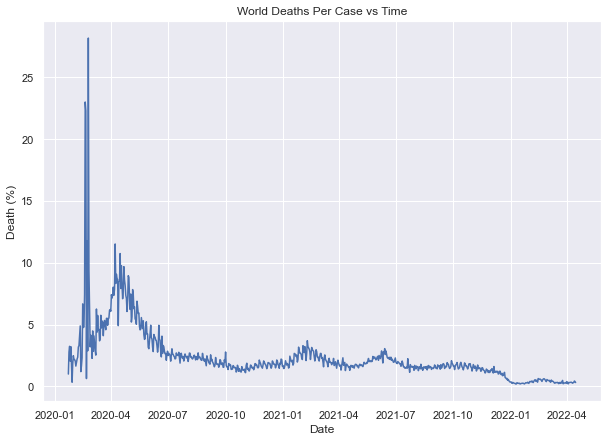

In [29]:
# change x axis incrementation because it is too much: do this by changing string date to datetime
daily_death_per_case['date'] = pd.to_datetime(daily_death_per_case['date'])

# make plot bigger
big = plt.figure()
big.set_figwidth(10)
big.set_figheight(7)

# labelling
plt.title('World Deaths Per Case vs Time')
plt.xlabel('Date')
plt.ylabel("Death (%)")

# line graph
plt.plot(daily_death_per_case.date, daily_death_per_case.deaths_per_case)

# show
plt.show()

#### -------------------- World Cases and Deaths --------------------

In [30]:
grouped_world_data = world_data.groupby(['location']).sum()
grouped_world_data.rename(columns={"new_cases":"total_cases", "new_deaths":"total_deaths"}, inplace=True)

# death percentage
world_death_percentage = (grouped_world_data['total_deaths'] / grouped_world_data['total_cases'])*100
world_death_percentage = pd.DataFrame(world_death_percentage, columns=['death_percentage'])

# join two tables
world_data_final = grouped_world_data.join(world_death_percentage)
world_data_final

# fixes grouping issues and accessing grouped columns
world_data_final.reset_index(inplace=True)
world_data_final = world_data_final[['total_cases', 'total_deaths', 'death_percentage']]
world_data_final

,total_cases,total_deaths,death_percentage
0,502454099.0,6155000.0,1.224988


#### -------------------- Population and Vaccinations --------------------

In [31]:
# relevant data
eighth_analysis = data[['iso_code', 'location', 'continent', 'date', 'population', 'total_vaccinations']]
eighth_analysis

# group by location
is_grouped_6 = eighth_analysis.groupby(['iso_code', 'location', 'continent']).max()
is_grouped_6

# vaccination percentage
vaccination_percentage = (is_grouped_6['total_vaccinations'] / is_grouped_6['population'])*100
vaccination_percentage = pd.DataFrame(vaccination_percentage, columns=['vaccination_percentage'])

# join tables
combined_4 = is_grouped_6.join(vaccination_percentage)

# keep continents only
combined_4 = combined_4.query("continent!=0 and population != 0 and total_vaccinations != 0")
combined_4.sort_values(by=['vaccination_percentage'], ascending=False, inplace=True)

# fixes grouping issues and accessing grouped columns
combined_4.reset_index(inplace=True)
combined_4

,iso_code,location,continent,date,population,total_vaccinations,vaccination_percentage
0,GIB,Gibraltar,Europe,2022-04-15,33691.0,119578.0,354.925648
1,CUB,Cuba,North America,2022-04-15,11317498.0,35556960.0,314.176861
2,CHL,Chile,South America,2022-04-16,19212362.0,51486776.0,267.987747
3,NIU,Niue,Oceania,2022-03-13,1614.0,4161.0,257.806691
4,SGP,Singapore,Asia,2022-04-15,5453600.0,13901512.0,254.905237
...,...,...,...,...,...,...,...
213,SSD,South Sudan,Africa,2022-04-15,11381377.0,645347.0,5.670201
214,YEM,Yemen,Asia,2022-04-15,30490639.0,814569.0,2.671538
215,HTI,Haiti,North America,2022-04-15,11541683.0,255729.0,2.215699
216,COD,Democratic Republic of Congo,Africa,2022-04-15,92377986.0,881240.0,0.953950


#### Geopandas World Map For Vaccinations

In [32]:
# merge on iso code
merged_data_4 = world_iso_sorted.merge(combined_4, how='left', left_on=['iso_a3'], right_on=['iso_code'])

# drop NaN
merged_data_4 = merged_data_4.dropna(subset=['iso_code'])

<AxesSubplot:title={'center':'Global Vaccination Per Population'}>

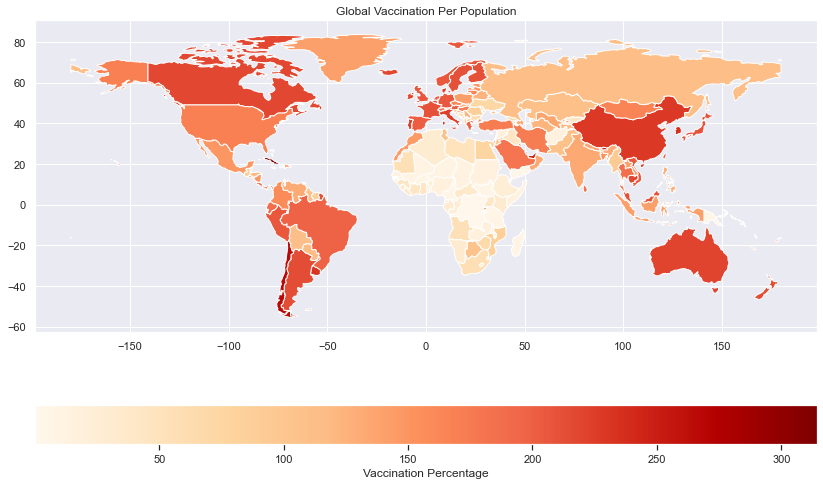

In [33]:
# geopandas plot
fig, ax = plt.subplots(1, 1, figsize=(14,9))
plt.title('Global Vaccination Per Population')

merged_data_4.plot(column='vaccination_percentage', ax=ax, legend=True, legend_kwds={'label': 'Vaccination Percentage', 'orientation':'horizontal'}, cmap='OrRd')

<Figure size 1080x1080 with 0 Axes>

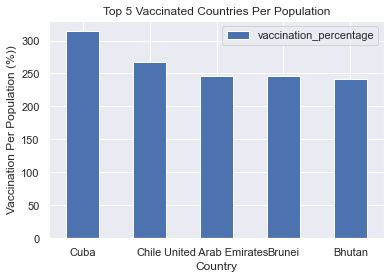

In [34]:
# top 5 global vaccination rate by population
top_5_4 = merged_data_4
top_5_4.sort_values(by='vaccination_percentage', ascending=False, inplace=True)
top_5_4 = top_5_4.head(5)

# plot a bar chart
plt.figure(figsize=(15,15))

# bar chart
top_5_4 = top_5_4.plot.bar(x='location', y='vaccination_percentage', rot=-0)

# labels
plt.xlabel('Country')
plt.ylabel('Vaccination Per Population (%))')
plt.title('Top 5 Vaccinated Countries Per Population')

# show
plt.show()

##  Same analysis using SQL Queries 

#### The pandas data analysis and visualisation was more so for verification as well as practice extracting data from a SQL database. However, the SQL queries will be used to create a dashboard

In [35]:
SERVER_NAME = 'DESKTOP-GR6T3L7'
DATABASE_NAME = 'Covid Project'

# connection string
conn = pyodbc.connect('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER=' + SERVER_NAME + '; \
                       DATABASE=' + DATABASE_NAME + '; \
                       Trusted_Connection=yes')

# cursor to extract data
cursor = conn.cursor()

#### ------------------------- Deaths per cases in the United Kingdom -------------------------

In [36]:
query_1 = """ SELECT location, date, total_cases, total_deaths, (total_deaths/total_cases * 100) AS DeathsPerCase
              FROM [Covid Project].dbo.[Automation]
              WHERE location = 'United Kingdom'
              ORDER BY 1, 2 """

sql_result_1 = pd.read_sql(query_1, conn)
sql_result_1

,location,date,total_cases,total_deaths,DeathsPerCase
0,United Kingdom,2020-01-31,2.0,0.0,0.000000
1,United Kingdom,2020-02-01,2.0,0.0,0.000000
2,United Kingdom,2020-02-02,2.0,0.0,0.000000
3,United Kingdom,2020-02-03,8.0,0.0,0.000000
4,United Kingdom,2020-02-04,8.0,0.0,0.000000
...,...,...,...,...,...
801,United Kingdom,2022-04-11,21711142.0,170264.0,0.784224
802,United Kingdom,2022-04-12,21749699.0,170552.0,0.784158
803,United Kingdom,2022-04-13,21787105.0,171210.0,0.785832
804,United Kingdom,2022-04-14,21819851.0,171560.0,0.786257


#### -------------------- Percentage of total cases in the United Kingdom vs Time --------------------

In [37]:
query_2 = """ SELECT location, date, (total_cases/population * 100) AS TotalCasesPerPopulationPercentage
              FROM [Covid Project].dbo.[Automation]
              WHERE location = 'United Kingdom'
              ORDER BY 2 """

sql_result_2 = pd.read_sql(query_2, conn)
sql_result_2

,location,date,TotalCasesPerPopulationPercentage
0,United Kingdom,2020-01-31,0.000003
1,United Kingdom,2020-02-01,0.000003
2,United Kingdom,2020-02-02,0.000003
3,United Kingdom,2020-02-03,0.000012
4,United Kingdom,2020-02-04,0.000012
...,...,...,...
801,United Kingdom,2022-04-11,31.831199
802,United Kingdom,2022-04-12,31.887728
803,United Kingdom,2022-04-13,31.942570
804,United Kingdom,2022-04-14,31.990579


#### -------------------- Death percentage in the world -------------------------

In [38]:
query_3 = """ SELECT location, SUM(new_cases) AS TotalCases, SUM(new_deaths) AS TotalDeaths, ROUND((SUM(new_deaths)/SUM(new_cases))*100, 2) AS DeathPercentage
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location
              HAVING SUM(new_cases) > 0 AND  SUM(new_deaths) > 0 -- gets rid of NULL
              ORDER BY 3 DESC """

sql_result_3 = pd.read_sql(query_3, conn)
sql_result_3

,location,TotalCases,TotalDeaths,DeathPercentage
0,United States,80612680.0,988558.0,1.23
1,Brazil,30142220.0,662154.0,2.20
2,India,43040947.0,514374.0,1.20
3,Russia,17790211.0,365540.0,2.05
4,Mexico,5725476.0,316842.0,5.53
...,...,...,...,...
203,Wallis and Futuna,454.0,7.0,1.54
204,Vanuatu,6109.0,7.0,0.11
205,Palau,4190.0,6.0,0.14
206,Montserrat,176.0,3.0,1.70


#### -------------------- Infection rate by looking at total cases against population -------------------------

In [39]:
query_4 = """ SELECT location, MAX(total_cases) as MaximumCases, population, (MAX(total_cases)/population)*100 AS InfectionRate
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location, population
              HAVING SUM(new_cases) > 0 AND  SUM(CAST(new_deaths as int)) > 0 -- gets rid of NULL
              ORDER BY 4 DESC """

sql_result_4 = pd.read_sql(query_4, conn)
sql_result_4

,location,MaximumCases,population,InfectionRate
0,Faeroe Islands,34658.0,4.905300e+04,70.654190
1,Denmark,3095605.0,5.813302e+06,53.250373
2,Andorra,40709.0,7.735400e+04,52.626884
3,Gibraltar,17494.0,3.369100e+04,51.924846
4,Cyprus,464366.0,8.960050e+05,51.826273
...,...,...,...,...
203,Tanzania,33851.0,6.149844e+07,0.055044
204,Chad,7378.0,1.691498e+07,0.043618
205,China,562762.0,1.444216e+09,0.038967
206,Yemen,11817.0,3.049064e+07,0.038756


#### -------------------- Death percentage for each country --------------------

In [40]:
query_5 = """ SELECT location, MAX(CAST(total_deaths AS int)) as TotalDeathsUpToDate, population, (MAX(CAST(total_deaths AS int))/population)*100 AS TotalDeathPerPopulation
              FROM [Covid Project].dbo.[Automation]
              WHERE continent <> '0' -- gets rid of the continents and limits to countries
              GROUP BY location, population
              HAVING MAX(total_cases) > 0 AND MAX(CAST(total_deaths as int)) > 0 -- gets rid of NULL
              ORDER BY 2 DESC """

sql_result_5 = pd.read_sql(query_5, conn)
sql_result_5

,location,TotalDeathsUpToDate,population,TotalDeathPerPopulation
0,United States,988558,3.329151e+08,0.296940
1,Brazil,662154,2.139934e+08,0.309427
2,India,521747,1.393409e+09,0.037444
3,Russia,365540,1.459120e+08,0.250521
4,Mexico,323903,1.302622e+08,0.248655
...,...,...,...,...
203,Vanuatu,7,3.144640e+05,0.002226
204,Wallis and Futuna,7,1.109400e+04,0.063097
205,Palau,6,1.817400e+04,0.033014
206,Montserrat,3,4.981000e+03,0.060229


#### -------------------- Continental Death Count --------------------

In [41]:
query_6 = """ SELECT location, MAX(CAST(total_deaths AS int)) AS TotalDeathCount
              FROM [Covid Project].dbo.Automation
              WHERE continent = '0' AND location NOT LIKE '%income%' AND location NOT LIKE '%European%' AND location NOT LIKE '%International%' AND location NOT LIKE '%World%'
              GROUP BY location
              ORDER BY 2 DESC """

sql_result_6 = pd.read_sql(query_6, conn)
sql_result_6

,location,TotalDeathCount
0,Europe,1797973
1,North America,1423989
2,Asia,1419646
3,South America,1291586
4,Africa,252476
5,Oceania,9962


#### -------------------- World Death percentage vs Date --------------------

In [42]:
query_7 = """ SELECT date, new_cases, new_deaths, ( new_deaths / new_cases)*100 AS DeathPercentagePerInfected
              FROM [Covid Project].dbo.Automation
              WHERE location = 'World' AND new_cases <> '0' """

sql_result_7 = pd.read_sql(query_7, conn)
sql_result_7

,date,new_cases,new_deaths,DeathPercentagePerInfected
0,2020-01-23,100.0,1.0,1.000000
1,2020-01-24,287.0,8.0,2.787456
2,2020-01-25,493.0,16.0,3.245436
3,2020-01-26,683.0,14.0,2.049780
4,2020-01-27,809.0,26.0,3.213844
...,...,...,...,...
809,2022-04-11,975317.0,2948.0,0.302261
810,2022-04-12,1036861.0,3303.0,0.318558
811,2022-04-13,1039901.0,4553.0,0.437830
812,2022-04-14,971952.0,3808.0,0.391789


#### -------------------- World Cases and Deaths --------------------

In [43]:
query_8 = """ SELECT SUM(new_cases) AS TotalCases, SUM(CAST(new_deaths AS int)) AS TotalDeaths, (SUM(CAST(new_deaths AS int))/SUM(new_cases))*100 AS DeathPercentage
              FROM [Covid Project].dbo.Automation
              WHERE continent  <> '0' """

sql_result_8 = pd.read_sql(query_8, conn)
sql_result_8

,TotalCases,TotalDeaths,DeathPercentage
0,502453378.0,6154985,1.224986


#### -------------------- Population and Vaccinations --------------------

In [44]:
query_9 = """ SELECT location, population, MAX(total_vaccinations) as total_vaccinations, (MAX(total_vaccinations)/population)*100 AS vaccination_percentage
              FROM [Covid Project].dbo.Automation
              WHERE continent <> '0' AND total_vaccinations <> '0' AND population <> '0'
              GROUP BY location, population
              ORDER BY 4 DESC """

sql_result_9 = pd.read_sql(query_9, conn)
sql_result_9

,location,population,total_vaccinations,vaccination_percentage
0,Gibraltar,33691.0,119578.0,354.925648
1,Cuba,11317498.0,35556960.0,314.176861
2,Chile,19212362.0,51486776.0,267.987747
3,Niue,1614.0,4161.0,257.806691
4,Singapore,5453600.0,13901512.0,254.905237
...,...,...,...,...
213,South Sudan,11381377.0,645347.0,5.670201
214,Yemen,30490639.0,814569.0,2.671538
215,Haiti,11541683.0,255729.0,2.215699
216,Democratic Republic of Congo,92377986.0,881240.0,0.953950


## Export SQL Queries into Datasets in SQL

In [45]:
# Save each query as a table of its own and export back to sql
quoted = urllib.parse.quote_plus('DRIVER={ODBC Driver 17 for SQL Server}; \
                       SERVER='+SERVER_NAME+'; \
                       DATABASE='+DATABASE_NAME+'; \
                       Trusted_Connection=yes')

engine = create_engine('mssql+pyodbc:///?odbc_connect={}'.format(quoted))

sql_result_1.to_sql('UK_Deaths_Per_case', schema='dbo', con=engine, if_exists='replace')
sql_result_2.to_sql('UK_Total_Cases', schema='dbo', con=engine, if_exists='replace')
sql_result_3.to_sql('Country_Death_Percentage', schema='dbo', con=engine, if_exists='replace')
sql_result_4.to_sql('Infection_Rate_Per_Population', schema='dbo', con=engine, if_exists='replace')
sql_result_5.to_sql('Country_Death_Percentage_Per_Population', schema='dbo', con=engine, if_exists='replace')
sql_result_6.to_sql('Continental_Death_Count', schema='dbo', con=engine, if_exists='replace')
sql_result_7.to_sql('World_Death_Percentage', schema='dbo', con=engine, if_exists='replace')
sql_result_8.to_sql('World_Cases_Deaths', schema='dbo', con=engine, if_exists='replace')
sql_result_9.to_sql('World_Population_Vaccination', schema='dbo', con=engine, if_exists='replace')

In [46]:
# close connection and remove cursor
cursor.close()
conn.close()

#### This SQL data is exported into Tableau to create dashboards: Preview of dahboard

## Time Log

In [47]:
# create text file to log automation
file = open("time_log.txt", "a")
day = datetime.datetime.now()
file.write(f"Time: {day}\n")
file.close()